## Imports

In [230]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, ConfusionMatrixDisplay, precision_recall_curve,
                             precision_score, recall_score, f1_score, roc_curve, roc_auc_score)

import xgboost as xgb

from scipy.stats import randint, uniform, boxcox

## Read in Data

In [231]:
train = pd.read_csv('data/train.csv')

In [232]:
# Check shape of train/test
train_shape = train.shape

print(f'Train shape: {train_shape}')

Train shape: (58592, 44)


In [233]:
# Inspect DataFrame
train.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [234]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [235]:
train.replace({'Yes': 1, 'No': 0}, inplace=True)

/var/folders/7y/311sp_hx0cd0mpz76xxlrr540000gn/T/ipykernel_17845/64444707.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.replace({'Yes': 1, 'No': 0}, inplace=True)


<Axes: >

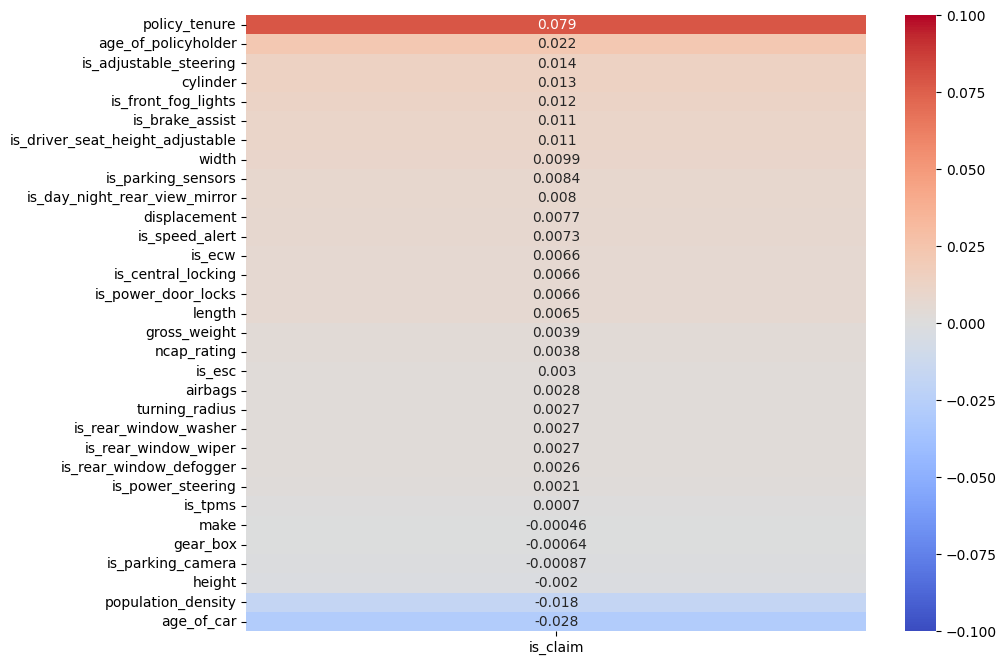

In [236]:
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = train.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True, vmax=0.1, vmin=-0.1)

In [237]:
corr_matrix_no_claim[['is_claim']]

,is_claim
policy_tenure,0.078747
age_of_policyholder,0.022435
is_adjustable_steering,0.013917
cylinder,0.013434
is_front_fog_lights,0.011825
is_brake_assist,0.010893
is_driver_seat_height_adjustable,0.010686
width,0.009947
is_parking_sensors,0.008419
is_day_night_rear_view_mirror,0.007989


## Drop Irrelevant Features
We'll drop several features that are expected not to be useful to the model. Features and justification for dropping:
* policy_id: Only used as a unique identifier
* engine_type: Provides little information beyond the combination of the fuel_type, displacement and max_power features
* displacement: Intrinsicly linked to engine torque/power, which are ultimatetly the features of most interest
* cylinders: Intrinsicly linked to engine torque/power, which are ultimatetly the features of most interest
* is_tpms: Very low or no correlation with target variable
* make: Very low or no correlation with target variable
* gear_box: Very low or no correlation with target variable
* is_parking_camera: Very low or no correlation with target variable

In [238]:
X_train = train.copy()
y_train = X_train['is_claim']

X_train = X_train.drop(columns=['is_claim'])

columns_to_drop = ['policy_id',
                   'displacement',
                   'cylinder',
                   'engine_type',
                   'is_tpms',
                   'make',
                   'gear_box',
                   'is_parking_camera'
                   ]

X_train.drop(columns=columns_to_drop, inplace=True)

## Feature Engineering
We'll start by converting the max torque to integer values. As it's likely the maximum torque alone, and not engine speed is relevant, we'll just extract the maximum torque value.

In [239]:
X_train['max_torque'].value_counts()

max_torque
113Nm@4400rpm     17796
60Nm@3500rpm      14948
250Nm@2750rpm     14018
82.1Nm@3400rpm     4173
91Nm@4250rpm       2373
200Nm@1750rpm      2114
200Nm@3000rpm      1598
85Nm@3000rpm       1209
170Nm@4000rpm       363
Name: count, dtype: int64

In [240]:
train['max_torque'] = train['max_torque'].apply(lambda x: float(x.split('Nm')[0]))

Check modified values:

In [241]:
train['max_torque'].value_counts()

max_torque
113.0    17796
60.0     14948
250.0    14018
82.1      4173
200.0     3712
91.0      2373
85.0      1209
170.0      363
Name: count, dtype: int64

Now we'll do the same for max power.

In [242]:
train['max_power'] = train['max_power'].apply(lambda x: float(x.split('bhp')[0]))

In [243]:
train['max_power'].value_counts()

max_power
88.50     17796
40.36     14948
113.45    14018
55.92      4173
67.06      2373
97.89      2114
88.77      1598
61.68      1209
118.36      363
Name: count, dtype: int64

<Axes: >

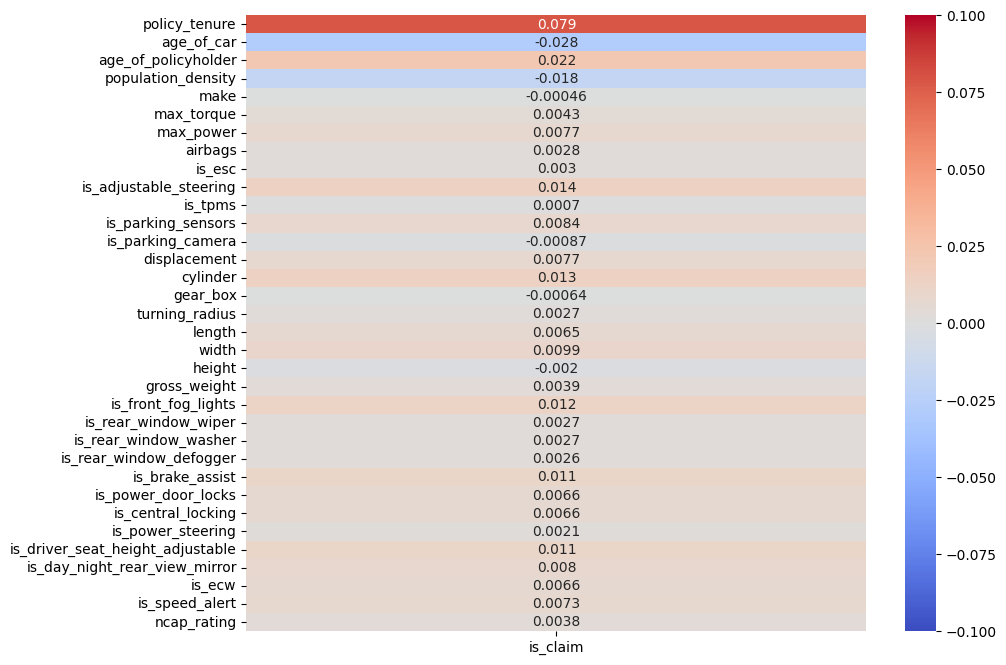

In [244]:
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = train.corr(numeric_only=True)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True, vmax=0.1, vmin=-0.1)

### Check Distributions of Numeric Features

In [245]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns.to_list()

binary_cols = [
            'is_esc',
            'is_adjustable_steering',
            'is_tpms',
            'is_parking_sensors',
            'is_parking_camera',
            'is_front_fog_lights',
            'is_rear_window_wiper',
            'is_rear_window_washer',
            'is_rear_window_defogger',
            'is_brake_assist',
            'is_power_door_locks',
            'is_central_locking',
            'is_power_steering',
            'is_driver_seat_height_adjustable',
            'is_day_night_rear_view_mirror',
            'is_ecw',
            'is_speed_alert'
            ]

numeric_cols = [col for col in numeric_cols if col not in binary_cols]

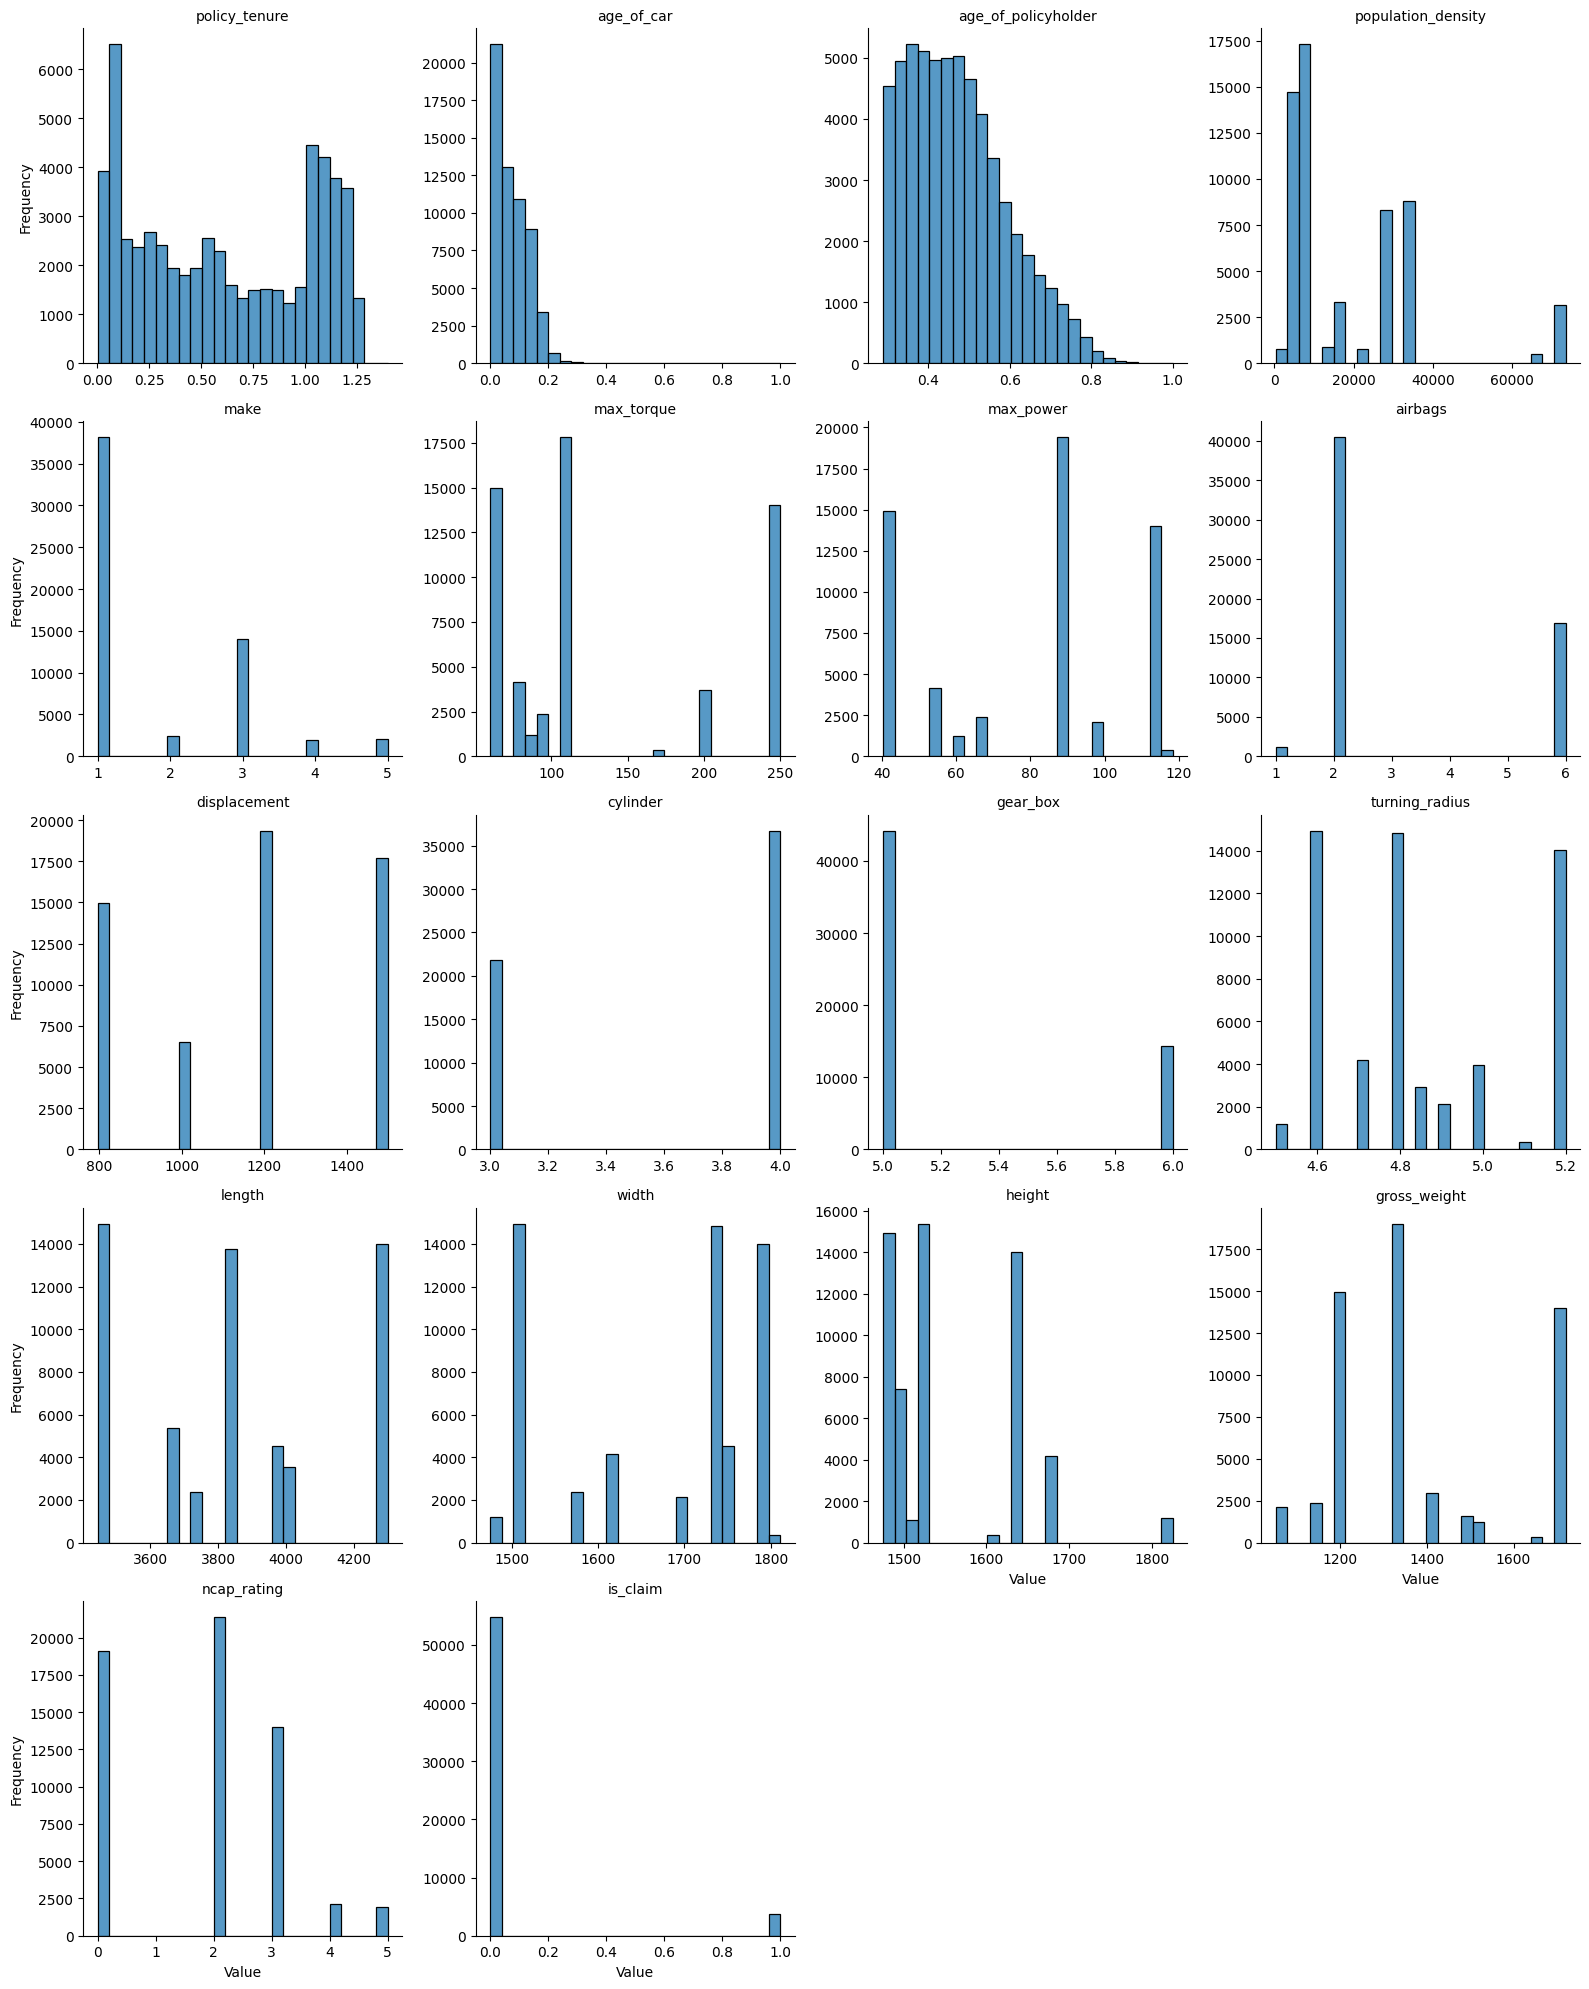

In [246]:
# Melt the DataFrame to long format for seaborn FacetGrid
melted_train = train[numeric_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

### Feature Transformation

From the histograms of the numerical features, we can observe:
* Policy tenure hhas a multimodal distribution - it would likely be beneficial to bucketise this feature
* Age of car and age of policy holder features roughly follows a power law - computing their log would likely be beneficial


In [247]:
train_trans = train.copy()

# Compute log of age_of_policy_holder
# Add small constant to avoid log(0) errors
ep = 1e-6
train_trans['age_of_policyholder'] = np.log(train_trans['age_of_policyholder'] + ep)

# Compute log of age_of_car
ep = 1e-6
train_trans['age_of_car'] = (train_trans['age_of_car'] + ep)**(0.7)

# Bucketise plocy tenure
# Define the bins
bins1 = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
train_trans['policy_tenure'] = pd.cut(train_trans['policy_tenure'], bins=bins1, labels=False, include_lowest=True)

# Bucketise population density
# Define the bins
bins2 = np.linspace(0,80000, 10)
train_trans['population_density'] = pd.cut(train_trans['population_density'], bins=bins2, labels=False, include_lowest=True)

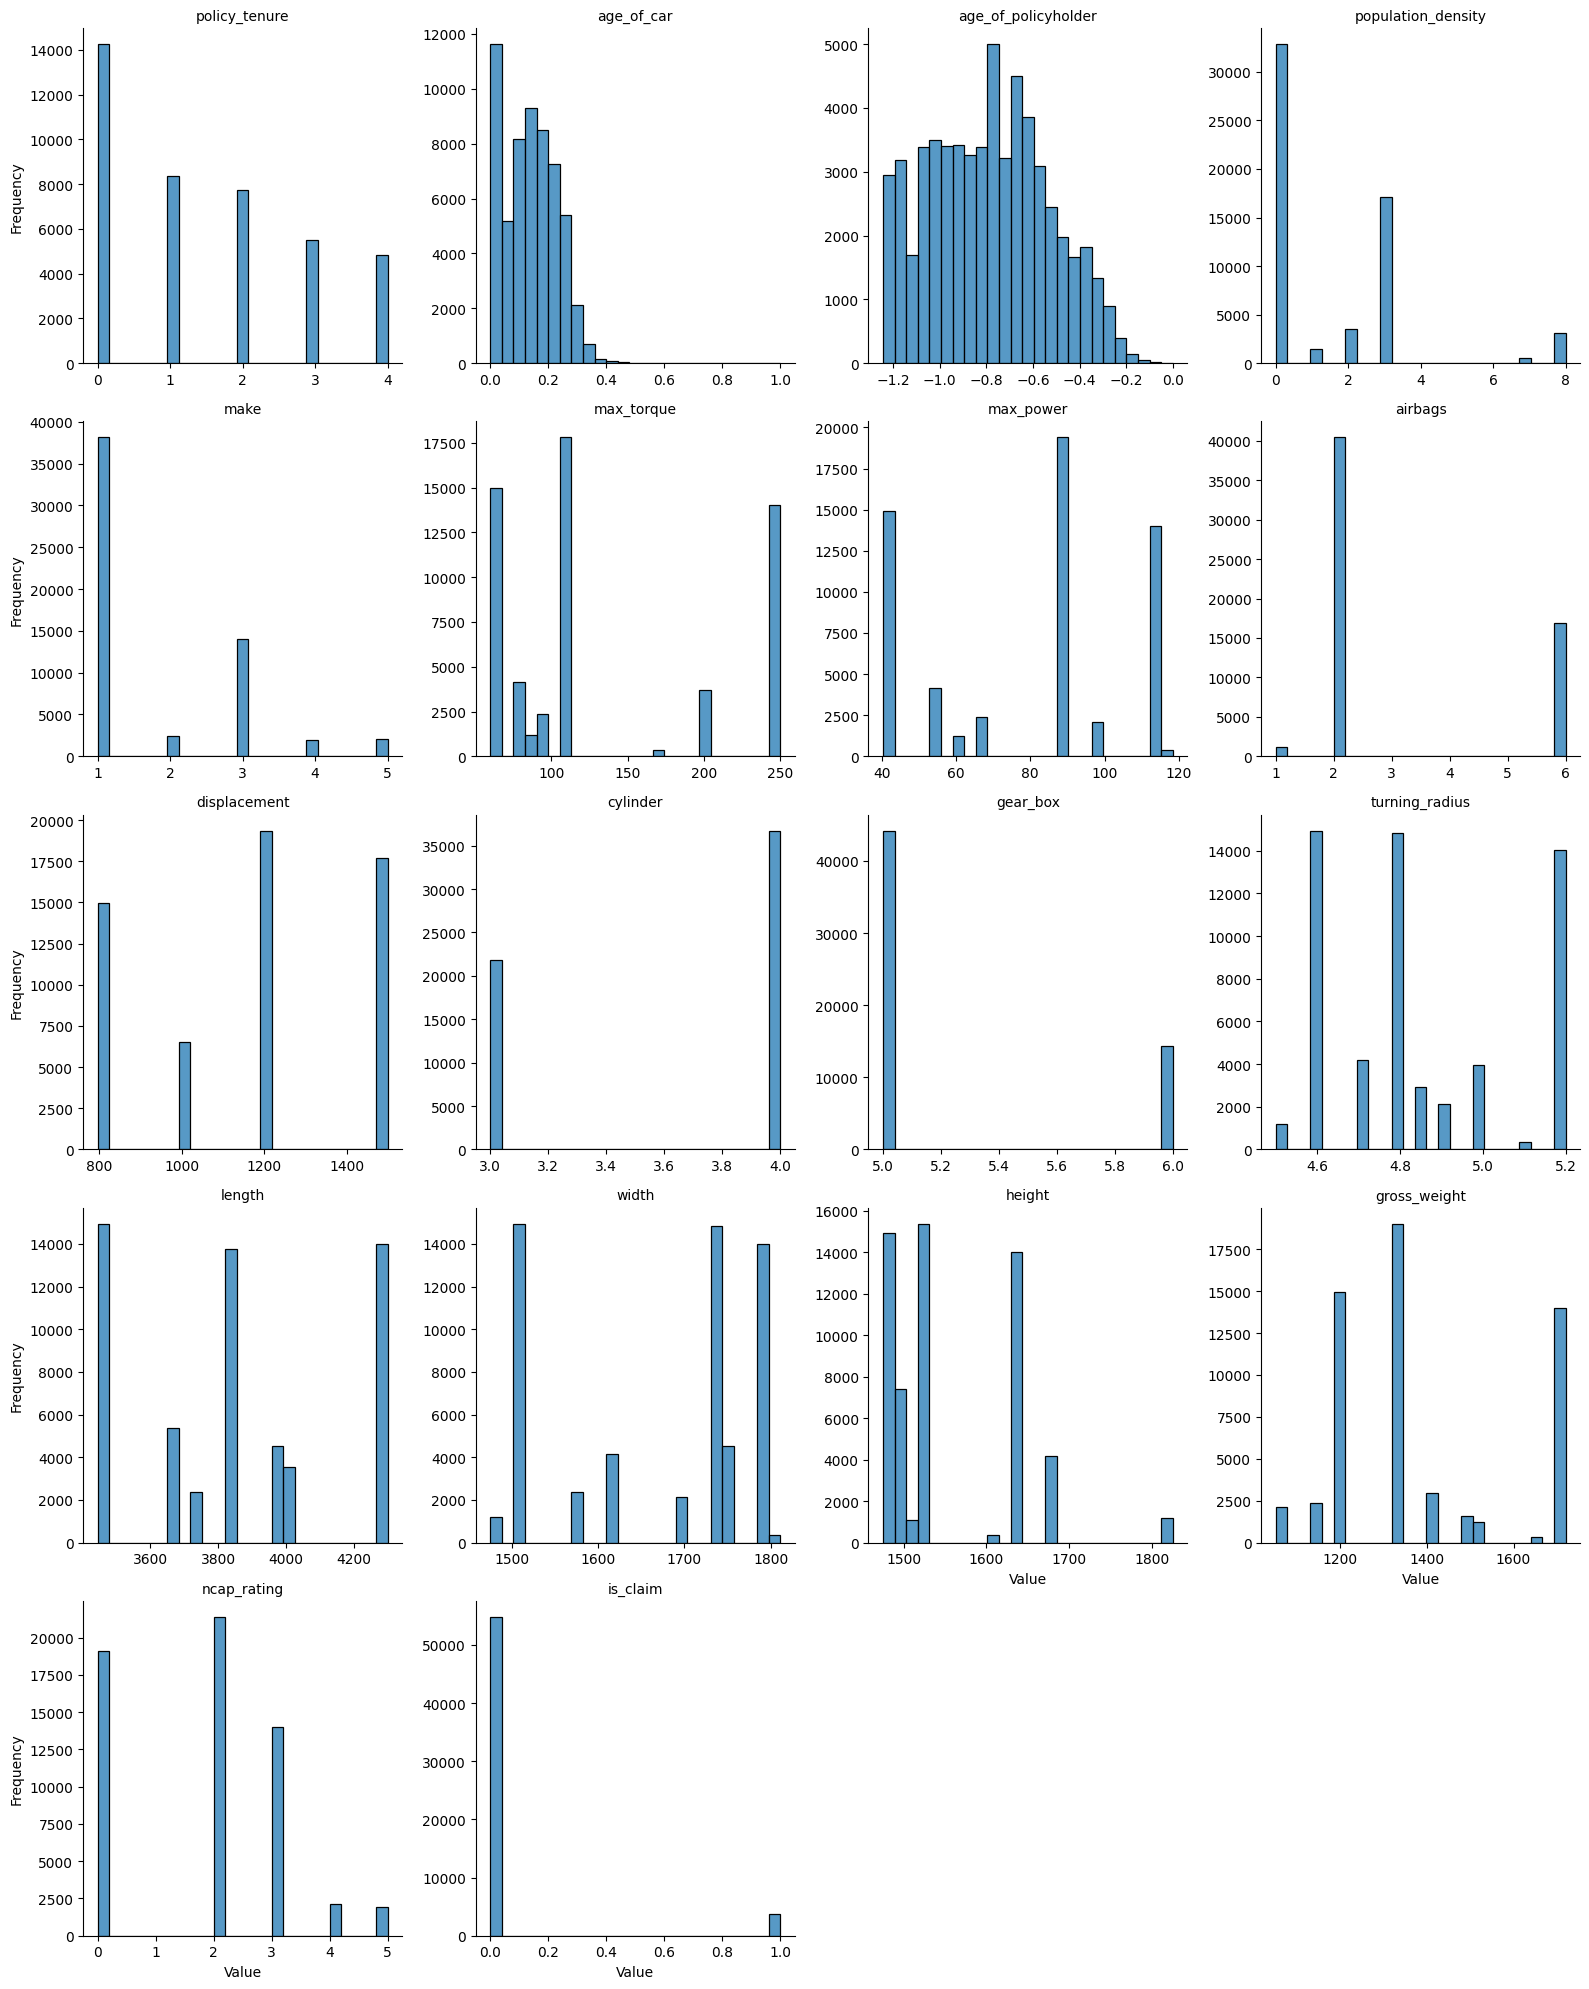

In [248]:
# Melt the DataFrame to long format for seaborn FacetGrid
melted_train_trans = train_trans[numeric_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_train_trans, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

## Create Data Pipline

In [249]:
X = train.copy()
y = train['is_claim']

X = train.drop(columns=['is_claim'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Check the balance of positive and negative classes after oversampling.

In [250]:
bucket_features = ['policy_tenure',
                   'population_density'
                   ]

age_of_car_feature = ['age_of_car']

age_of_policyholder_feature = ['age_of_policyholder']

num_features_unscaled = [
                'max_torque',
                'max_power',
                'airbags',
                'turning_radius',
                'length',
                'width',
                'height',
                'gross_weight']

cat_features = ['area_cluster',
                'segment',
                'model',
                'fuel_type',
                'rear_brakes_type',
                'transmission_type',
                'steering_type',
                'ncap_rating']

bin_features = ['is_esc',
                'is_adjustable_steering',
                'is_parking_sensors',
                'is_front_fog_lights',
                'is_rear_window_wiper',
                'is_rear_window_washer',
                'is_rear_window_defogger',
                'is_brake_assist',
                'is_power_door_locks',
                'is_central_locking',
                'is_power_steering',
                'is_driver_seat_height_adjustable',
                'is_day_night_rear_view_mirror',
                'is_ecw',
                'is_speed_alert']

columns_to_drop = ['policy_id',
                   'displacement',
                   'cylinder',
                   'engine_type',
                   'is_tpms',
                   'make',
                   'gear_box',
                   'is_parking_camera'
                   ]


Create a custom transformer to drop the rows of low importance:

In [251]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        return None

Create custom transformer to raise age_of_car to defined power between 0-1:

In [252]:
class PowerRaiseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ep=1e-6, power=0.7):
        self.ep = ep
        self.power = power
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = (X + self.ep) ** self.power
        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        return ['age_of_car']

In [253]:
class LogTransformer(TransformerMixin):
    def __init__(self, eps=1e-6):
        self.eps = eps
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log(X + self.eps)
    
    def get_feature_names_out(self, input_features=None):
        return ['age_of_policyholder']

We see the following features have already been scaled:
* age_of_car
* age_of_policyholder

The following features require scaling:
* population_density
* max_torque
* max_power

We can now define features for each pipeline:

In [254]:
# Pipeline for columns to drop
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(columns_to_drop))
])

# Pipeline for pre-scaled policy tenure feature
bucket_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('binariser', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'))
])

# Pipeline for pre-scaled numerical features
age_of_car_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('power_raise_transformer', PowerRaiseTransformer(ep=1e-6, power=0.7)),
    ('scaler', StandardScaler())
])

# Pipeline for pre-scaled numerical features
age_of_holder_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler())
])


# Pipeline for unscaled numerical features
num_unscaled_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# Pipeline for binary features
bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('binarizer', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

In [255]:
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, columns_to_drop),
    ('bucket_features', bucket_pipeline, bucket_features),
    ('age_of_car', age_of_car_pipeline, age_of_car_feature),
    ('age_of_policyholder', age_of_holder_pipeline, age_of_policyholder_feature),
    ('num_unscaled', num_unscaled_pipeline, num_features_unscaled),
    ('cat', cat_pipeline, cat_features),
    ('bin', bin_pipeline, bin_features)
])

In [256]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Over-sample data to combat imbalance of classes. We split the test/train sets before oversampling to prevent data leakage.

In [257]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_prepared, y_train)

Check the class imbalance before over-sampling:

In [258]:
y_train.value_counts()

is_claim
0    43881
1     2992
Name: count, dtype: int64

In [259]:
y_train_resampled.value_counts()

is_claim
0    43881
1    43881
Name: count, dtype: int64

In [260]:
df_X_train_prepared = pd.DataFrame(
    X_train_resampled,
    columns=preprocess_pipeline.get_feature_names_out(),
)
df_X_train_prepared.head(6)

,bucket_features__policy_tenure,bucket_features__population_density,age_of_car__age_of_car,age_of_policyholder__age_of_policyholder,num_unscaled__max_torque,num_unscaled__max_power,num_unscaled__airbags,num_unscaled__turning_radius,num_unscaled__length,num_unscaled__width,...,bin__is_power_steering_0,bin__is_power_steering_1,bin__is_driver_seat_height_adjustable_0,bin__is_driver_seat_height_adjustable_1,bin__is_day_night_rear_view_mirror_0,bin__is_day_night_rear_view_mirror_1,bin__is_ecw_0,bin__is_ecw_1,bin__is_speed_alert_0,bin__is_speed_alert_1
0,3.0,2.0,0.796154,-0.746292,-0.291952,0.344903,-0.618911,-0.230962,-0.016875,0.560280,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,0.0,-0.205177,0.731976,-1.017408,-1.394725,-0.618911,-1.108991,-1.302761,-1.404432,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,-0.020123,0.996173,-1.017408,-1.394725,-0.618911,-1.108991,-1.302761,-1.404432,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1.0,0.324429,1.801021,-0.291952,0.344903,-0.618911,-0.230962,-0.016875,0.560280,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,4.0,1.0,0.324429,0.142869,1.583283,1.246518,1.566210,1.525097,1.445820,1.051457,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
5,3.0,0.0,-0.020123,-0.457611,1.583283,1.246518,1.566210,1.525097,1.445820,1.051457,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [261]:
if df_X_train_prepared.isnull().sum().sum() > 0:
    print("Data contains NaN values. Please handle them before training.")

## Logistic Regression

In [262]:
# Init the model
lr_clf = LogisticRegression(max_iter=150)

# Train model
lr_clf.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=150)

In [263]:
# Make predictions on the training set
lr_train_predictions = lr_clf.predict(X_train_resampled)

# Evaluate the model
lr_accuracy = accuracy_score(y_train_resampled, lr_train_predictions)
print("Accuracy on training set:", lr_accuracy)

# Cross-validation to get a more robust estimate of performance
lr_cv_scores = cross_val_score(lr_clf, X_train_resampled, y_train_resampled, cv=10)
print("Cross-validation scores:", lr_cv_scores)
print("Mean cross-validation score:", lr_cv_scores.mean())

# Print classification report
print("Classification Report:")
print(classification_report(y_train_resampled, lr_train_predictions))

Accuracy on training set: 0.5954741231968278
Cross-validation scores: [0.59086248 0.58938134 0.59742479 0.59252507 0.60186873 0.59229717
 0.60255242 0.59047402 0.5892206  0.60255242]
Mean cross-validation score: 0.5949159042408948
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.57      0.58     43881
           1       0.59      0.62      0.61     43881

    accuracy                           0.60     87762
   macro avg       0.60      0.60      0.60     87762
weighted avg       0.60      0.60      0.60     87762



## Random Forest

In [264]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [265]:
# Make predictions on the training set
forest_train_predictions = forest_clf.predict(X_train_resampled)

# Evaluate the model
forest_accuracy = accuracy_score(y_train_resampled, forest_train_predictions)
print("Accuracy on training set:", forest_accuracy)

# Cross-validation to get a more robust estimate of performance
forest_cv_scores = cross_val_score(forest_clf, X_train_resampled, y_train_resampled, cv=10)
print("Cross-validation scores:", forest_cv_scores)
print("Mean cross-validation score:", forest_cv_scores.mean())

# Print classification report
print("Classification Report:")
print(classification_report(y_train_resampled, forest_train_predictions))

Accuracy on training set: 0.9885827579134477
Cross-validation scores: [0.75002848 0.93596901 0.93128988 0.93482224 0.9385825  0.93561987
 0.93755697 0.93539198 0.94074749 0.93596171]
Mean cross-validation score: 0.9175970146137938
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43881
           1       0.99      0.99      0.99     43881

    accuracy                           0.99     87762
   macro avg       0.99      0.99      0.99     87762
weighted avg       0.99      0.99      0.99     87762



## K-Nearest Neighbors (KNN)

In [266]:
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier()

In [267]:
# Make predictions on the training set
knn_train_predictions = knn_clf.predict(X_train_resampled)

# Evaluate the model
knn_accuracy = accuracy_score(y_train_resampled, knn_train_predictions)
print("Accuracy on training set:", knn_accuracy)

# Cross-validation to get a more robust estimate of performance
knn_cv_scores = cross_val_score(knn_clf, X_train_resampled, y_train_resampled, cv=10)
print("Cross-validation scores:", knn_cv_scores)
print("Mean cross-validation score:", knn_cv_scores.mean())

# Print classification report
print("Classification Report:")
print(classification_report(y_train_resampled, knn_train_predictions))

Accuracy on training set: 0.5241220573824662
Cross-validation scores: [0.82693403 0.82533895 0.83135825 0.82976299 0.8353464  0.83261167
 0.83523245 0.83056062 0.83500456 0.83101641]
Mean cross-validation score: 0.8313166331701662
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68     43881
           1       0.97      0.05      0.09     43881

    accuracy                           0.52     87762
   macro avg       0.74      0.52      0.39     87762
weighted avg       0.74      0.52      0.39     87762



## XGBoost

In [268]:
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_clf.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [269]:
# Make predictions on the training set
train_predictions = xgb_clf.predict(X_train_resampled)

# Evaluate the model
xgb_accuracy = accuracy_score(y_train_resampled, train_predictions)
print("Accuracy on training set:", xgb_accuracy)

# Cross-validation to get a more robust estimate of performance
xgb_cv_scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, cv=10)
print("Cross-validation scores:", xgb_cv_scores)
print("Mean cross-validation score:", xgb_cv_scores.mean())

# Print classification report
print("Classification Report:")
print(classification_report(y_train_resampled, train_predictions))

Accuracy on training set: 0.9389599143137121
Cross-validation scores: [0.66024838 0.96638943 0.96843665 0.96365087 0.9663856  0.96114403
 0.96763902 0.96479034 0.96467639 0.9680948 ]
Mean cross-validation score: 0.9351455487944011
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     43881
           1       0.98      0.89      0.94     43881

    accuracy                           0.94     87762
   macro avg       0.94      0.94      0.94     87762
weighted avg       0.94      0.94      0.94     87762



## Model Scores Summary

In [270]:
# Create scores df
scores_df = pd.DataFrame([lr_cv_scores, forest_cv_scores, knn_cv_scores, xgb_cv_scores])
scores_df = scores_df.T
scores_df.columns=['Logistic Regression','Random Forest', 'K-nearest Neighbors', 'XGBoost']

In [271]:
scores_df.head()

,Logistic Regression,Random Forest,K-nearest Neighbors,XGBoost
0,0.590862,0.750028,0.826934,0.660248
1,0.589381,0.935969,0.825339,0.966389
2,0.597425,0.931290,0.831358,0.968437
3,0.592525,0.934822,0.829763,0.963651
4,0.601869,0.938582,0.835346,0.966386


<Axes: >

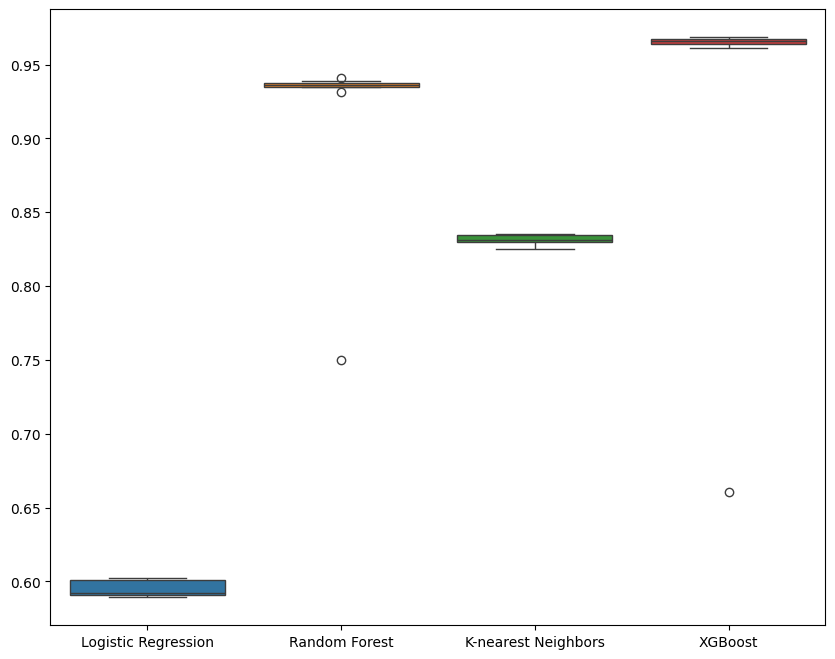

In [272]:
# Plot scores
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(scores_df)

The random forest and XGBoost models appear to be the best at generalising, so we'll proceed with these models and look at tuning hyperparameters to further improve performance.

## Hyperparameter Tuning

We'll initially use RandomizedSearchCV to cover a broad range of hyperparameters, then use GridSearchCV for a more refined search after reducing the parameter space.

### Random Forest - Randomised Search

In [273]:
# Create a parameters grid for grid search
forest_param_grid = [
    {'n_estimators': randint(low=100, high=500),
     'max_depth': randint(low=10, high = 100),
     'min_samples_split': randint(low=2, high=10),
     'min_samples_leaf': randint(low=1, high=10),
     'bootstrap': [True, False]
    }]

forest_random_search = RandomizedSearchCV(
    forest_clf,
    forest_param_grid,
    cv= 3,
    n_jobs=-1,
    n_iter=30,
    random_state=42
    )

forest_random_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1482e87a0>,
                                         'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x146f33170>,
                                         'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x146f329c0>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14846d7f0>}],
                   random_state=42)

In [274]:
forest_random_search.best_params_

{'bootstrap': True,
 'max_depth': 44,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 149}

In [275]:
forest_random_search.best_score_

0.9081265240081128

### Random Forest - Grid Search
Now we've reduced the search space for the hyperparamters, we'll do a grid search with a smaller search space.

In [277]:
# Create a parameters grid for grid search
forest_param_grid = [
    {'n_estimators': [125, 150, 175],
     'max_depth': [40, 50, 60],
     'min_samples_split': [3, 5, 7],
     'min_samples_leaf': [1],
     'bootstrap': [True]
    }]

forest_grid_search = GridSearchCV(
    forest_clf,
    forest_param_grid,
    cv= 3,
    n_jobs=-1,
    )

forest_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'max_depth': [40, 50, 60],
                          'min_samples_leaf': [1],
                          'min_samples_split': [3, 5, 7],
                          'n_estimators': [125, 150, 175]}])

In [278]:
forest_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 150}

In [279]:
forest_grid_search.best_score_

0.9089127412775461

### XGBoost - Randomised Search

In [280]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=100, high=500),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 10),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
}

xgb_random_search = RandomizedSearchCV(
    xgb_clf,
    xgb_param_grid,
    cv=5,
    n_jobs=-1,
    random_state=42,
    n_iter=30
    )

xgb_random_search.fit(X_train_resampled, y_train_resampled)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14952f860>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14952e6c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1428e7740>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14952c920>},
                   random_state=42)

In [281]:
xgb_random_search.best_params_

{'colsample_bytree': 0.6688412526636073,
 'learning_rate': 0.203117483419074,
 'max_depth': 8,
 'n_estimators': 313,
 'subsample': 0.8872127425763265}

In [282]:
xgb_random_search.best_score_

0.9416386372180495

### XGBoost - Grid Search

In [283]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [450, 500, 550],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [6, 8, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7]
}

xgb_grid_search = GridSearchCV(
    xgb_clf,
    xgb_param_grid,
    cv=3,
    n_jobs=-1,
    )

xgb_grid_search.fit(X_train_resampled, y_train_resampled)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [6, 8, 10],
                         'n_estimators': [450, 500, 550],
                         'subsample': [0.7, 0.8, 0.9]})

In [284]:
xgb_grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 450,
 'subsample': 0.9}

In [285]:
xgb_grid_search.best_score_

0.9414780884665345

### Precision/Recall

In [286]:
y_forest_pred = cross_val_predict(forest_grid_search.best_estimator_, X_train_resampled, y_train_resampled, cv=3)
y_xgb_pred = cross_val_predict(xgb_grid_search.best_estimator_, X_train_resampled, y_train_resampled, cv=3)

In [287]:
# Compute precision scores
forest_precision_score = precision_score(y_train_resampled, y_forest_pred)
xgb_precision_score = precision_score(y_train_resampled, y_xgb_pred)

# Compute recall scores
forest_recall_score = recall_score(y_train_resampled, y_forest_pred)
xgb_recall_score = recall_score(y_train_resampled, y_xgb_pred)

# Compute f1 scores
forest_f1_score = f1_score(y_train_resampled, y_forest_pred)
xgb_f1_score = f1_score(y_train_resampled, y_xgb_pred)

print(f'Forest scores:\nPrecision: {forest_precision_score}\nRecall: {forest_recall_score}\nF1: {forest_f1_score}\n')
print(f'XGBoost scores:\nPrecision: {xgb_precision_score}\nRecall: {xgb_recall_score}\nF1: {xgb_f1_score}')

Forest scores:
Precision: 0.9178835091641632
Recall: 0.8981791663818053
F1: 0.9079244413729556

XGBoost scores:
Precision: 0.9764159063522121
Recall: 0.904810738132677
F1: 0.9392505677517032


In [288]:
y_forest_probas = cross_val_predict(forest_grid_search.best_estimator_, X_train_resampled, y_train_resampled, cv=3,method='predict_proba')
y_xgb_probas = cross_val_predict(xgb_grid_search.best_estimator_, X_train_resampled, y_train_resampled, cv=3,method='predict_proba')

In [289]:
y_forest_scores = y_forest_probas[:,1]
y_xgb_scores = y_xgb_probas[:,1]
forest_precisions, forest_recalls, forest_thresholds = precision_recall_curve(y_train_resampled, y_forest_scores)
xgb_precisions, xgb_recalls, xgb_thresholds = precision_recall_curve(y_train_resampled, y_xgb_scores)

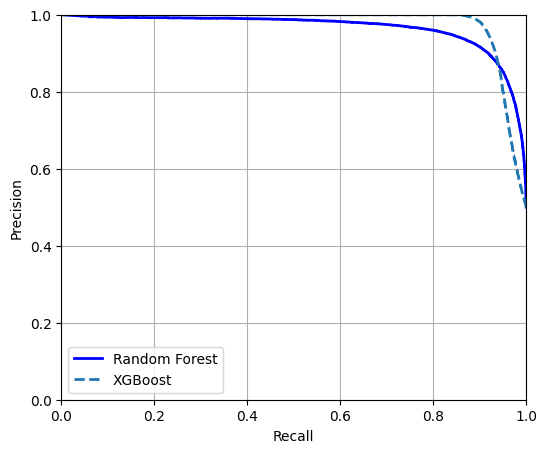

In [290]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(forest_recalls, forest_precisions, "b-", linewidth=2, label="Random Forest")
plt.plot(xgb_recalls, xgb_precisions, "--", linewidth=2, label="XGBoost")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [291]:
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_train_resampled, y_forest_scores)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_train_resampled, y_xgb_scores)

### Error Analysis

In [ ]:
y_train_forest_pred = cross_val_predict(forest_grid_search.best_estimator_, X_train_resampled, y_train_resampled, cv=3)
y_train_xgb_pred = cross_val_predict(xgb_grid_search.best_estimator_, X_train_resampled, y_train_resampled, cv=3)

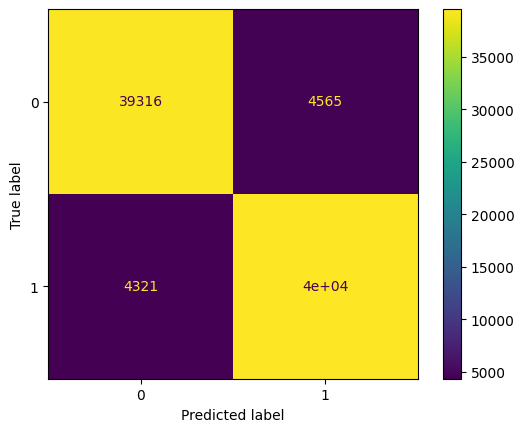

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_train_forest_pred)

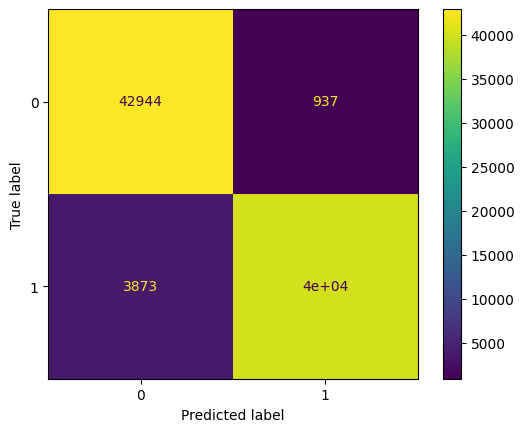

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_train_xgb_pred)